# CourtRankRL - Korpusz Adatelemzés



**Szakdolgozati elemzés a magyar bírósági döntések korpuszáról**



Ez a notebook átfogó elemzést nyújt a CourtRankRL projekt által feldolgozott bírósági dokumentumokról:

- Szöveghossz és struktúra jellemzők

- Metaadat eloszlások (bíróság, jogterület, év)

- Szókészlet és nyelvi jellemzők

- Dokumentum-szintű aggregált statisztikák

- FAISS embedding elemzés (ha elérhető)



**Forrás adatok:**

- `chunks.jsonl` - Docling által feldolgozott chunk-ok

- `processed_docs.jsonl` - Dokumentum-szintű összesítő

- `faiss_index.bin` - Dense embedding index (opcionális)


In [1]:
# Importok és környezet beállítása
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import faiss
from pathlib import Path
from typing import Dict, List
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Plot stílus beállítása (szakdolgozati minőség)
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Projekt konfiguráció
import sys
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))
from configs import config

print("=" * 60)
print("CourtRankRL - Korpusz Adatelemzés")
print("=" * 60)
print(f"\nAdatforrások:")
print(f"  Chunks: {config.CHUNKS_JSONL}")
print(f"  Processed docs: {config.PROCESSED_DOCS_LIST}")
print(f"  FAISS index: {config.FAISS_INDEX_PATH}")
print(f"  Chunk ID map: {config.CHUNK_ID_MAP_PATH}")


CourtRankRL - Korpusz Adatelemzés

Adatforrások:
  Chunks: /Users/zelenyianszkimate/Documents/CourtRankRL/data/processed/chunks.jsonl
  Processed docs: /Users/zelenyianszkimate/Documents/CourtRankRL/data/processed/processed_docs.jsonl
  FAISS index: /Users/zelenyianszkimate/Documents/CourtRankRL/data/index/faiss_index.bin
  Chunk ID map: /Users/zelenyianszkimate/Documents/CourtRankRL/data/index/chunk_id_map.npy


## 1. Adatok betöltése

Chunk-ok és dokumentumok betöltése a feldolgozott JSONL fájlokból.


In [2]:
# Chunk adatok betöltése
print("\n" + "=" * 60)
print("1. ADATOK BETÖLTÉSE")
print("=" * 60)

chunks_data = []
if config.CHUNKS_JSONL.exists():
    print(f"\n📂 Chunks betöltése: {config.CHUNKS_JSONL}")
    with open(config.CHUNKS_JSONL, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            if line.strip():
                try:
                    chunk = json.loads(line)
                    chunks_data.append(chunk)
                except json.JSONDecodeError:
                    continue
    
    df_chunks = pd.DataFrame(chunks_data)
    print(f"✅ Betöltve: {len(df_chunks):,} chunk")
    print(f"   Oszlopok: {', '.join(df_chunks.columns)}")
else:
    print(f"❌ Chunks fájl nem található: {config.CHUNKS_JSONL}")
    print("   Futtassa: uv run courtrankrl build")
    df_chunks = pd.DataFrame()

# Dokumentumok betöltése
docs_data = []
if config.PROCESSED_DOCS_LIST.exists():
    print(f"\n📂 Dokumentumok betöltése: {config.PROCESSED_DOCS_LIST}")
    with open(config.PROCESSED_DOCS_LIST, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                try:
                    doc = json.loads(line)
                    docs_data.append(doc)
                except json.JSONDecodeError:
                    continue
    
    df_docs = pd.DataFrame(docs_data)
    print(f"✅ Betöltve: {len(df_docs):,} dokumentum")
else:
    print(f"⚠️ Dokumentum fájl nem található: {config.PROCESSED_DOCS_LIST}")
    df_docs = pd.DataFrame()

if not df_chunks.empty:
    print(f"\n📊 Korpusz mérete:")
    print(f"   Dokumentumok: {df_chunks['doc_id'].nunique():,}")
    print(f"   Chunk-ok: {len(df_chunks):,}")
    print(f"   Átlag chunk/dokumentum: {len(df_chunks) / df_chunks['doc_id'].nunique():.1f}")
else:
    print("\n❌ Nincs betölthető adat az elemzéshez!")



1. ADATOK BETÖLTÉSE

📂 Chunks betöltése: /Users/zelenyianszkimate/Documents/CourtRankRL/data/processed/chunks.jsonl
✅ Betöltve: 2,964,527 chunk
   Oszlopok: chunk_id, doc_id, text, court, domain, year, source_path

📂 Dokumentumok betöltése: /Users/zelenyianszkimate/Documents/CourtRankRL/data/processed/processed_docs.jsonl
✅ Betöltve: 45,103 dokumentum

📊 Korpusz mérete:
   Dokumentumok: 43,959
   Chunk-ok: 2,964,527
   Átlag chunk/dokumentum: 67.4


## 2. Szöveghossz elemzés

Chunk-ok és dokumentumok méretének részletes elemzése karakterekben, szavakban és becsült tokenekben.



2. SZÖVEGHOSSZ ELEMZÉS

📏 Chunk-szintű statisztikák:
         char_count    word_count  token_count_est
count  2.964527e+06  2.964527e+06     2.964527e+06
mean   4.849023e+02  6.304193e+01     1.208512e+02
std    1.605432e+02  2.134667e+01     4.013425e+01
min    1.000000e+00  1.000000e+00     0.000000e+00
25%    3.920000e+02  5.000000e+01     9.800000e+01
50%    5.390000e+02  6.900000e+01     1.340000e+02
75%    6.130000e+02  7.900000e+01     1.530000e+02
max    1.628000e+04  2.020000e+02     4.070000e+03

📄 Dokumentum-szintű statisztikák:
         char_count     word_count  token_count_est    num_chunks
count  4.395900e+04   43959.000000     43959.000000  43959.000000
mean   3.270106e+04    4251.450374      8150.018790     67.438454
std    3.994246e+04    5274.621449      9954.799087     82.444368
min    6.450000e+02      91.000000       161.000000      2.000000
25%    1.629300e+04    2114.000000      4061.000000     34.000000
50%    2.506600e+04    3249.000000      6247.000000     

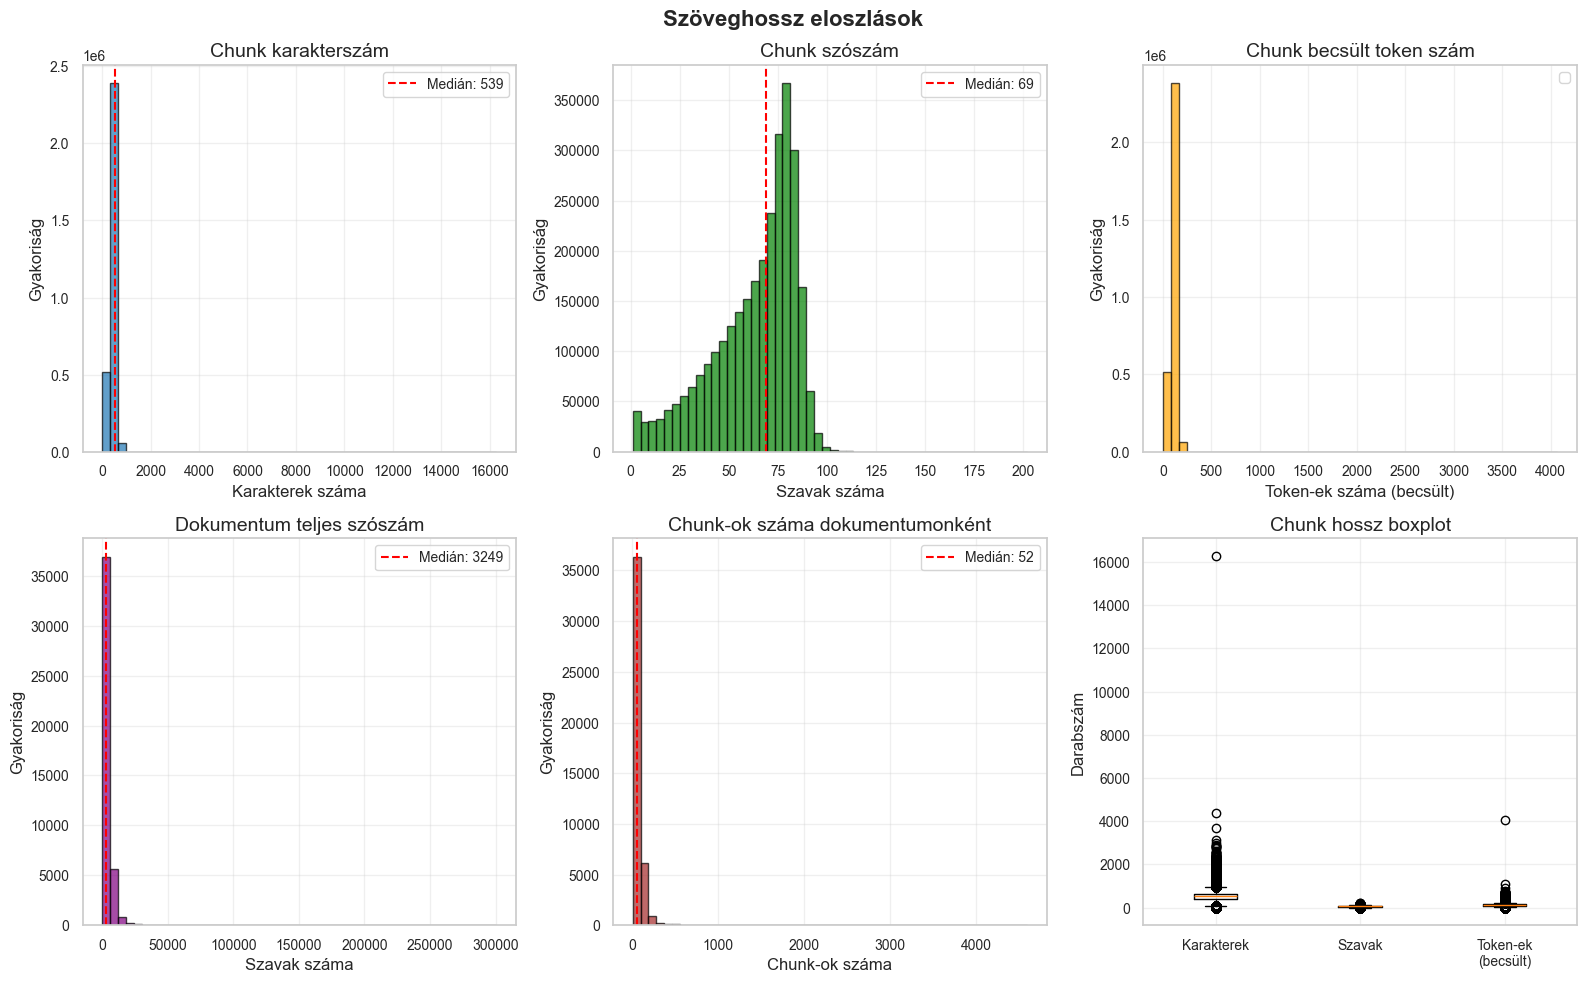

In [3]:
if not df_chunks.empty and 'text' in df_chunks.columns:
    print("\n" + "=" * 60)
    print("2. SZÖVEGHOSSZ ELEMZÉS")
    print("=" * 60)
    
    # Szöveghossz számítások
    df_chunks['char_count'] = df_chunks['text'].astype(str).str.len()
    df_chunks['word_count'] = df_chunks['text'].astype(str).str.split().str.len()
    df_chunks['token_count_est'] = (df_chunks['char_count'] / 4).astype(int)  # Becslés: 1 token ≈ 4 karakter
    
    print("\n📏 Chunk-szintű statisztikák:")
    stats = df_chunks[['char_count', 'word_count', 'token_count_est']].describe()
    print(stats.to_string())
    
    # Dokumentum-szintű aggregálás
    doc_stats = df_chunks.groupby('doc_id').agg({
        'char_count': 'sum',
        'word_count': 'sum',
        'token_count_est': 'sum',
        'chunk_id': 'count'
    }).reset_index().rename(columns={'chunk_id': 'num_chunks'})
    
    print(f"\n📄 Dokumentum-szintű statisztikák:")
    print(doc_stats[['char_count', 'word_count', 'token_count_est', 'num_chunks']].describe().to_string())
    
    # Vizualizáció
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle('Szöveghossz eloszlások', fontsize=16, fontweight='bold')
    
    # Chunk karakterszám
    axes[0, 0].hist(df_chunks['char_count'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Chunk karakterszám')
    axes[0, 0].set_xlabel('Karakterek száma')
    axes[0, 0].set_ylabel('Gyakoriság')
    axes[0, 0].axvline(df_chunks['char_count'].median(), color='red', linestyle='--', label=f'Medián: {df_chunks["char_count"].median():.0f}')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Chunk szószám
    axes[0, 1].hist(df_chunks['word_count'], bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[0, 1].set_title('Chunk szószám')
    axes[0, 1].set_xlabel('Szavak száma')
    axes[0, 1].set_ylabel('Gyakoriság')
    axes[0, 1].axvline(df_chunks['word_count'].median(), color='red', linestyle='--', label=f'Medián: {df_chunks["word_count"].median():.0f}')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Chunk token becslés
    axes[0, 2].hist(df_chunks['token_count_est'], bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 2].set_title('Chunk becsült token szám')
    axes[0, 2].set_xlabel('Token-ek száma (becsült)')
    axes[0, 2].set_ylabel('Gyakoriság')
    axes[0, 2].legend()
    axes[0, 2].grid(alpha=0.3)
    
    # Dokumentum szószám
    axes[1, 0].hist(doc_stats['word_count'], bins=50, edgecolor='black', alpha=0.7, color='purple')
    axes[1, 0].set_title('Dokumentum teljes szószám')
    axes[1, 0].set_xlabel('Szavak száma')
    axes[1, 0].set_ylabel('Gyakoriság')
    axes[1, 0].axvline(doc_stats['word_count'].median(), color='red', linestyle='--', label=f'Medián: {doc_stats["word_count"].median():.0f}')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Dokumentum chunk száma
    axes[1, 1].hist(doc_stats['num_chunks'], bins=50, edgecolor='black', alpha=0.7, color='brown')
    axes[1, 1].set_title('Chunk-ok száma dokumentumonként')
    axes[1, 1].set_xlabel('Chunk-ok száma')
    axes[1, 1].set_ylabel('Gyakoriság')
    axes[1, 1].axvline(doc_stats['num_chunks'].median(), color='red', linestyle='--', label=f'Medián: {doc_stats["num_chunks"].median():.0f}')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    # Boxplot összehasonlítás
    data_to_plot = [df_chunks['char_count'], df_chunks['word_count'], df_chunks['token_count_est']]
    axes[1, 2].boxplot(data_to_plot, labels=['Karakterek', 'Szavak', 'Token-ek\n(becsült)'])
    axes[1, 2].set_title('Chunk hossz boxplot')
    axes[1, 2].set_ylabel('Darabszám')
    axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n❌ Nincs szöveg adat az elemzéshez")



3. METAADAT ELOSZLÁSOK

🏛️  Bíróságok (top 15):
   Egyedi bíróságok: 86
court
mint felülvizsgálati bíróság     7441
Fővárosi Törvényszék             6760
Fővárosi Ítélőtábla              6027
Budapest Környéki Törvényszék    3015
Debreceni Törvényszék            2123
Miskolci Törvényszék             1359
Győri Ítélőtábla                 1319
Veszprémi Törvényszék            1298
mint másodfokú bíróság           1129
Győri Törvényszék                 948
SZEGEDI TÖRVÉNYSZÉK               928
Szegedi Ítélőtábla                927
Debreceni Ítélőtábla              878
Pécsi Ítélőtábla                  870
Szegedi Törvényszék               781

⚖️  Jogterületek:
   Egyedi jogterületek: 36
domain
K                       12006
I                        8688
P                        3211
V                        3121
PF                       2738
BF                       2547
B                        2139
közigazgatási jog      1740
büntetőjog             1351
G                        130

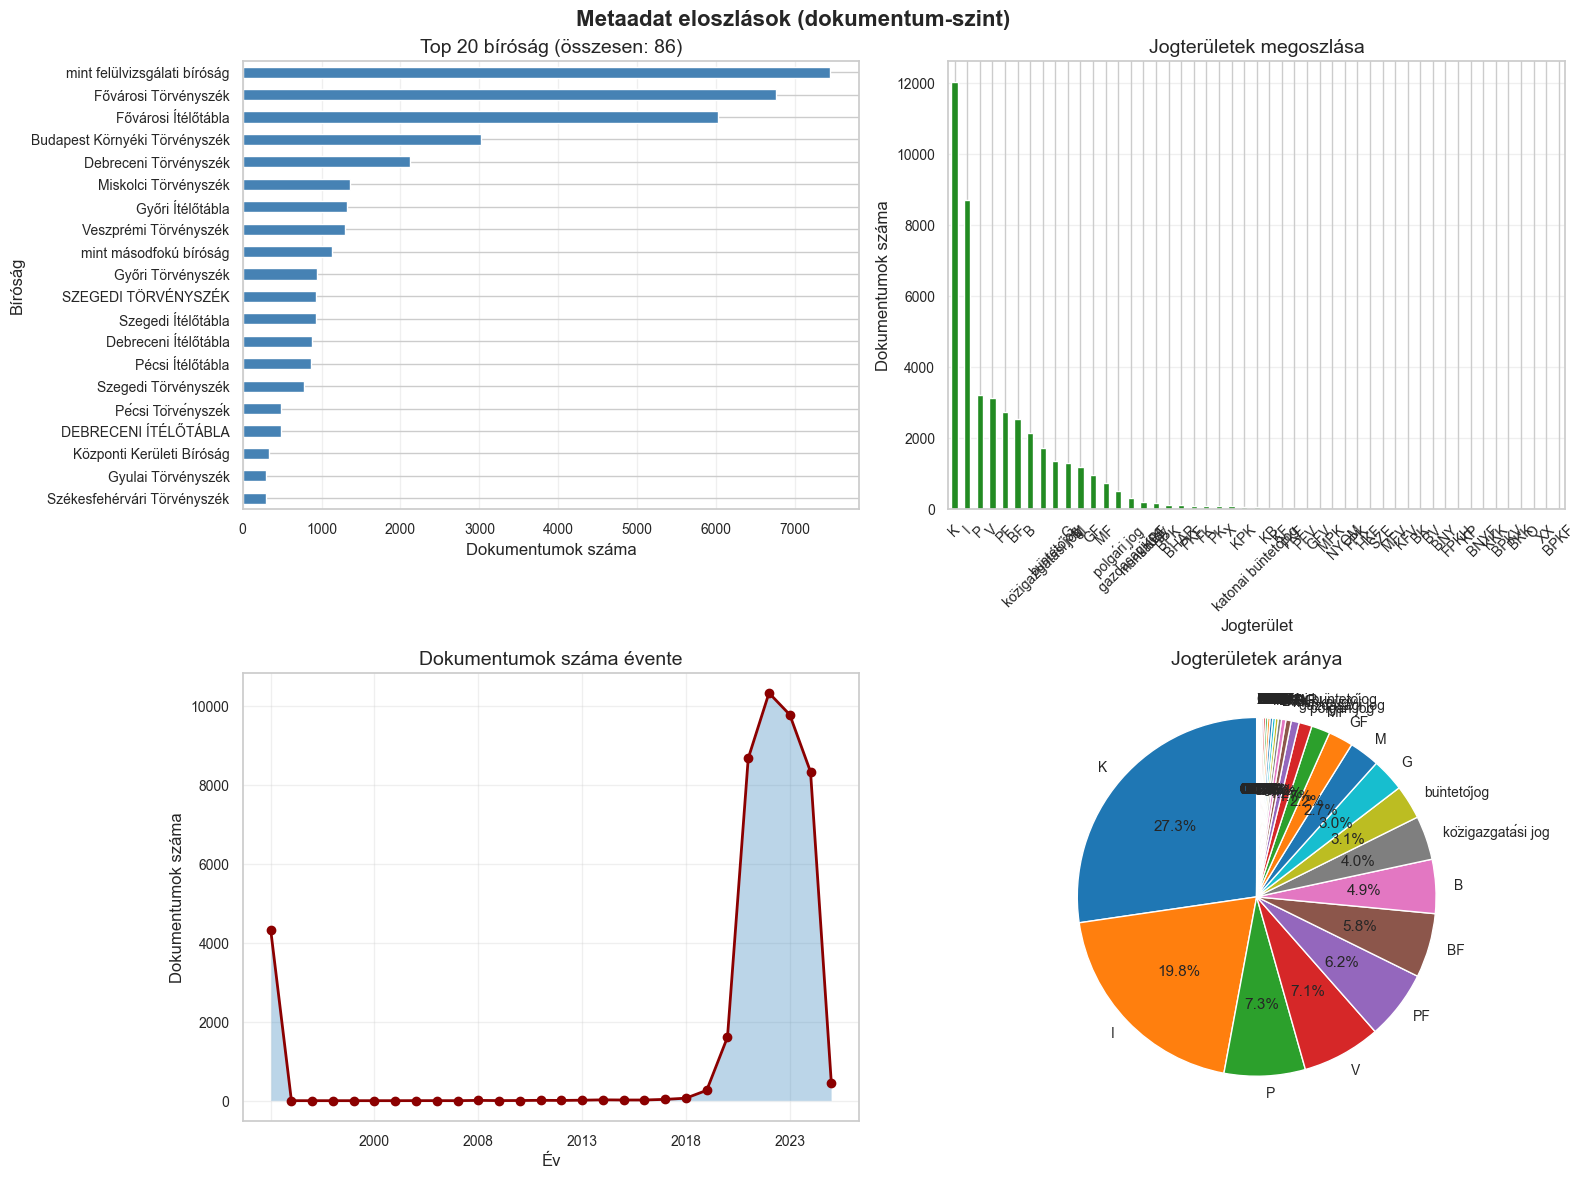

In [4]:
if not df_chunks.empty:
    print("\n" + "=" * 60)
    print("3. METAADAT ELOSZLÁSOK")
    print("=" * 60)
    
    # Dokumentum-szintű aggregálás (egy dokumentum = egy sor)
    df_docs_meta = df_chunks.groupby('doc_id').first().reset_index()
    df_docs_meta = df_docs_meta[['doc_id', 'court', 'domain', 'year']].copy()
    
    # Bíróságok
    if 'court' in df_docs_meta.columns:
        print(f"\n🏛️  Bíróságok (top 15):")
        court_counts = df_docs_meta['court'].value_counts()  # type: ignore
        print(f"   Egyedi bíróságok: {court_counts.nunique()}")
        print(court_counts.head(15).to_string())
    
    # Jogterületek
    if 'domain' in df_docs_meta.columns:
        print(f"\n⚖️  Jogterületek:")
        domain_counts = df_docs_meta['domain'].value_counts()  # type: ignore
        print(f"   Egyedi jogterületek: {domain_counts.nunique()}")
        print(domain_counts.to_string())
    
    # Évek
    if 'year' in df_docs_meta.columns:
        print(f"\n📅 Évek:")
        year_counts = df_docs_meta['year'].value_counts().sort_index()  # type: ignore
        print(f"   Időszak: {year_counts.index.min()} - {year_counts.index.max()}")
        print(year_counts.to_string())
    
    # Vizualizáció
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Metaadat eloszlások (dokumentum-szint)', fontsize=16, fontweight='bold')
    
    # Bíróságok (top 20)
    if 'court' in df_docs_meta.columns:
        court_counts.head(20).plot(kind='barh', ax=axes[0, 0], color='steelblue')
        axes[0, 0].set_title(f'Top 20 bíróság (összesen: {court_counts.nunique()})')
        axes[0, 0].set_xlabel('Dokumentumok száma')
        axes[0, 0].set_ylabel('Bíróság')
        axes[0, 0].invert_yaxis()
        axes[0, 0].grid(axis='x', alpha=0.3)
    
    # Jogterületek
    if 'domain' in df_docs_meta.columns:
        domain_counts.plot(kind='bar', ax=axes[0, 1], color='forestgreen')
        axes[0, 1].set_title('Jogterületek megoszlása')
        axes[0, 1].set_xlabel('Jogterület')
        axes[0, 1].set_ylabel('Dokumentumok száma')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Évek idősor
    if 'year' in df_docs_meta.columns:
        year_counts.plot(kind='line', ax=axes[1, 0], marker='o', color='darkred', linewidth=2)
        axes[1, 0].set_title('Dokumentumok száma évente')
        axes[1, 0].set_xlabel('Év')
        axes[1, 0].set_ylabel('Dokumentumok száma')
        axes[1, 0].grid(alpha=0.3)
        axes[1, 0].fill_between(year_counts.index, year_counts.values, alpha=0.3)
    
    # Jogterület pie chart
    if 'domain' in df_docs_meta.columns:
        axes[1, 1].pie(domain_counts.values, labels=domain_counts.index, autopct='%1.1f%%', startangle=90)
        axes[1, 1].set_title('Jogterületek aránya')
    
    plt.tight_layout()
    plt.show()
else:
    print("\n❌ Nincs metaadat az elemzéshez")


## 4. Szókészlet és nyelvi jellemzők

Gyakori szavak, szókészlet mérete és nyelvi diverzitás elemzése.



4. SZÓKÉSZLET ÉS NYELVI JELLEMZŐK

📊 Mintavétel: 20,000 chunk elemzése

📚 Szókészlet statisztikák:
   Összes szó (token): 1,260,631
   Egyedi szavak: 121,936
   Szókészlet diverzitás: 0.0967
   Átlagos szóhossz: 7.69 karakter

🔤 Top 30 leggyakoribb szó:
    1. a                     114,994 ( 9.12%)
    2. az                     46,932 ( 3.72%)
    3. hogy                   21,627 ( 1.72%)
    4. és                     21,547 ( 1.71%)
    5. nem                    19,235 ( 1.53%)
    6. felperes               10,361 ( 0.82%)
    7. §                       8,727 ( 0.69%)
    8. bíróság                 7,766 ( 0.62%)
    9. alperes                 7,568 ( 0.60%)
   10. is                      6,318 ( 0.50%)
   11. alapján                 5,774 ( 0.46%)
   12. szerint                 5,646 ( 0.45%)
   13. (1)                     5,359 ( 0.43%)
   14. –                       4,999 ( 0.40%)
   15. elsőfokú                3,646 ( 0.29%)
   16. bekezdése               3,541 ( 0.28%)
   17. ál

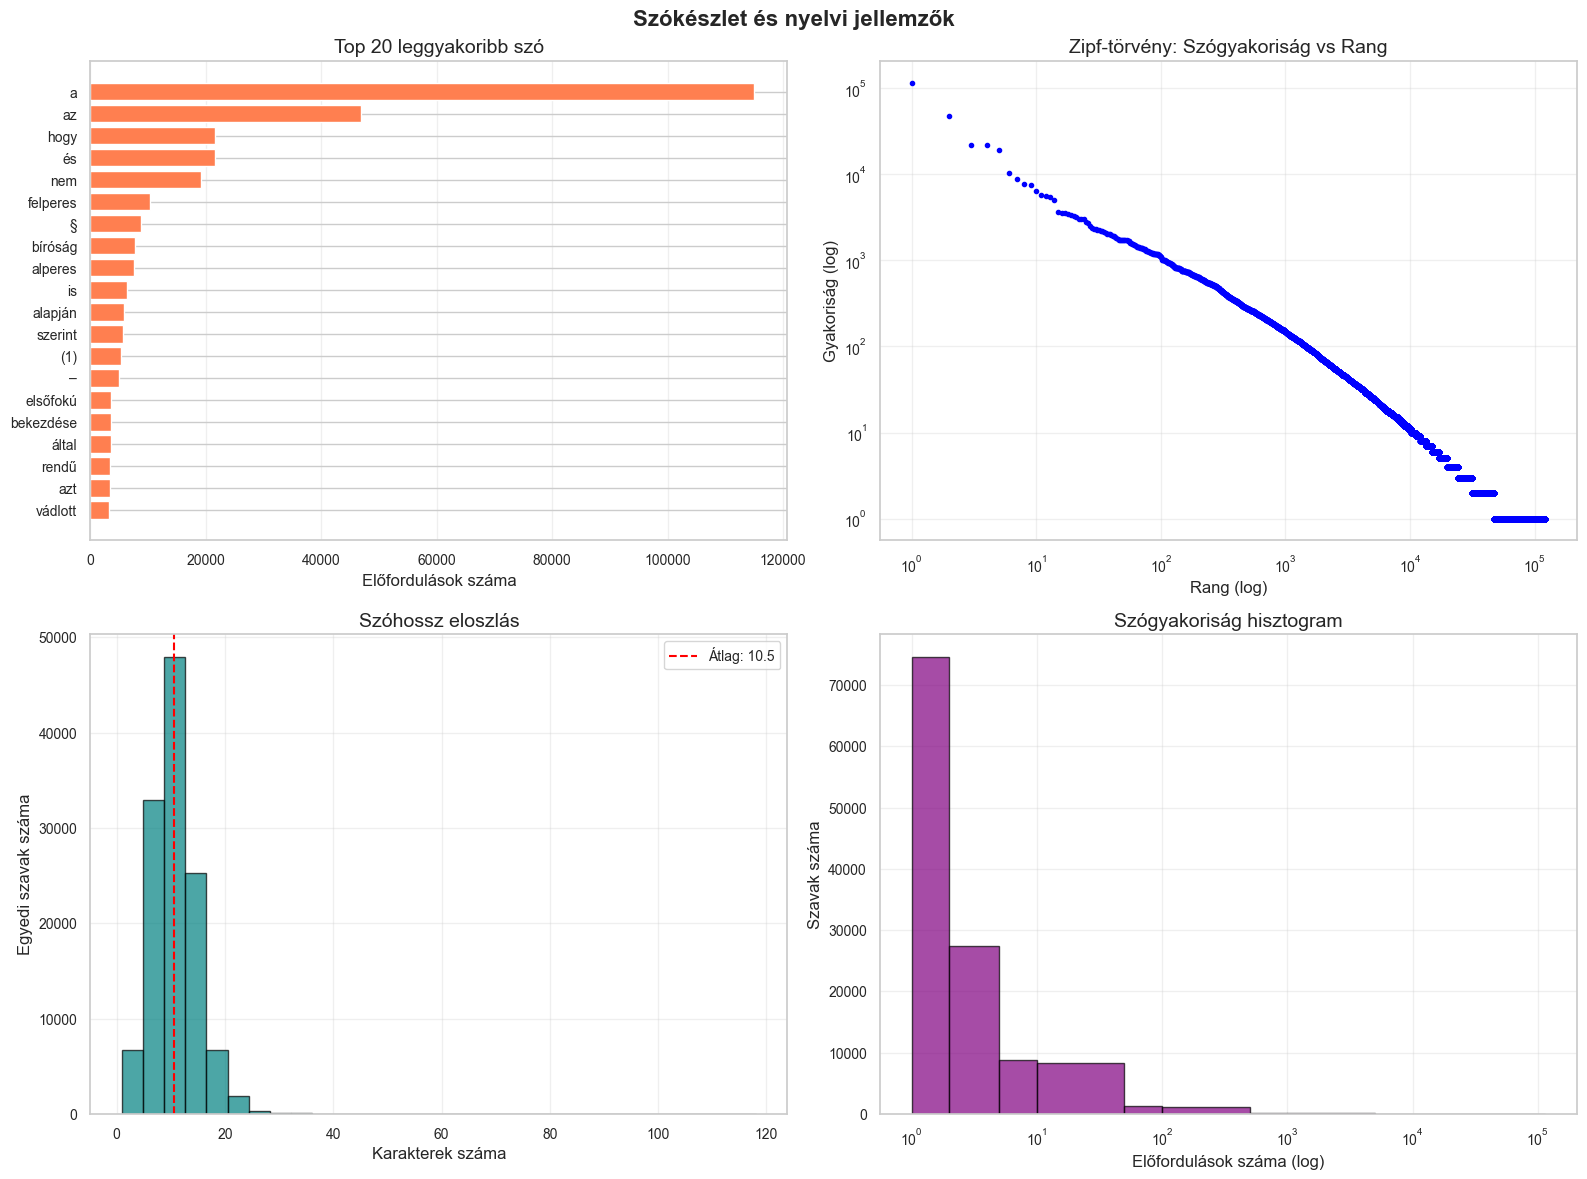

In [5]:
if not df_chunks.empty and 'text' in df_chunks.columns:
    print("\n" + "=" * 60)
    print("4. SZÓKÉSZLET ÉS NYELVI JELLEMZŐK")
    print("=" * 60)
    
    # Mintavétel a teljesítmény érdekében (max 20k chunk)
    sample_size = min(20000, len(df_chunks))
    df_sample = df_chunks.sample(n=sample_size, random_state=42)
    print(f"\n📊 Mintavétel: {sample_size:,} chunk elemzése")
    
    # Szavak gyűjtése
    all_words = []
    total_chars = 0
    
    for text in df_sample['text'].astype(str):
        words = text.lower().split()
        all_words.extend(words)
        total_chars += len(text)
    
    word_counts = Counter(all_words)
    unique_words = len(word_counts)
    total_words = len(all_words)
    
    print(f"\n📚 Szókészlet statisztikák:")
    print(f"   Összes szó (token): {total_words:,}")
    print(f"   Egyedi szavak: {unique_words:,}")
    print(f"   Szókészlet diverzitás: {unique_words/total_words:.4f}")
    print(f"   Átlagos szóhossz: {total_chars/total_words:.2f} karakter")
    
    # Top 30 leggyakoribb szó
    top_words = word_counts.most_common(30)
    print(f"\n🔤 Top 30 leggyakoribb szó:")
    for i, (word, count) in enumerate(top_words, 1):
        print(f"   {i:2d}. {word:20s} {count:8,} ({100*count/total_words:5.2f}%)")
    
    # Magyar töltelékszavak
    stop_words_hu = ['a', 'az', 'és', 'de', 'hogy', 'van', 'volt', 'lesz', 'is', 'nem', 
                     'amely', 'ami', 'csak', 'vagy', 'mint', 'miatt', 'által', 'lehet']
    stop_word_count = sum(word_counts.get(word, 0) for word in stop_words_hu)
    print(f"\n⚠️  Magyar töltelékszavak aránya: {100*stop_word_count/total_words:.2f}%")
    
    # Vizualizáció
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Szókészlet és nyelvi jellemzők', fontsize=16, fontweight='bold')
    
    # Top 20 szó
    top_20_words = [w[0] for w in top_words[:20]]
    top_20_counts = [w[1] for w in top_words[:20]]
    axes[0, 0].barh(range(20), top_20_counts, color='coral')
    axes[0, 0].set_yticks(range(20))
    axes[0, 0].set_yticklabels(top_20_words)
    axes[0, 0].set_title('Top 20 leggyakoribb szó')
    axes[0, 0].set_xlabel('Előfordulások száma')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # Szógyakoriság eloszlás (log-log)
    frequencies = sorted(word_counts.values(), reverse=True)
    ranks = range(1, len(frequencies) + 1)
    axes[0, 1].loglog(ranks, frequencies, 'b.')
    axes[0, 1].set_title('Zipf-törvény: Szógyakoriság vs Rang')
    axes[0, 1].set_xlabel('Rang (log)')
    axes[0, 1].set_ylabel('Gyakoriság (log)')
    axes[0, 1].grid(alpha=0.3)
    
    # Szóhossz eloszlás
    word_lengths = [len(word) for word in word_counts.keys()]
    axes[1, 0].hist(word_lengths, bins=30, edgecolor='black', alpha=0.7, color='teal')
    axes[1, 0].set_title('Szóhossz eloszlás')
    axes[1, 0].set_xlabel('Karakterek száma')
    axes[1, 0].set_ylabel('Egyedi szavak száma')
    axes[1, 0].axvline(np.mean(word_lengths), color='red', linestyle='--', label=f'Átlag: {np.mean(word_lengths):.1f}')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Gyakoriság hisztogram (log skála)
    freq_bins = [1, 2, 5, 10, 50, 100, 500, 1000, 5000, max(frequencies)]
    axes[1, 1].hist(frequencies, bins=freq_bins, edgecolor='black', alpha=0.7, color='purple')
    axes[1, 1].set_xscale('log')
    axes[1, 1].set_title('Szógyakoriság hisztogram')
    axes[1, 1].set_xlabel('Előfordulások száma (log)')
    axes[1, 1].set_ylabel('Szavak száma')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n❌ Nincs szöveg adat a szókészlet elemzéshez")


## 5. FAISS Embedding elemzés (opcionális)

Ha létezik FAISS index, elemezzük az embedding vektorok jellemzőit.


In [6]:
if config.FAISS_INDEX_PATH.exists() and config.CHUNK_ID_MAP_PATH.exists():
    print("\n" + "=" * 60)
    print("5. FAISS EMBEDDING ELEMZÉS")
    print("=" * 60)
    
    try:
        # FAISS index betöltése
        index = faiss.read_index(str(config.FAISS_INDEX_PATH))
        print(f"\n✅ FAISS index betöltve")
        print(f"   Vektorok száma: {index.ntotal:,}")
        print(f"   Dimenzió: {index.d}")
        print(f"   Index típus: {type(index).__name__}")
        
        # Chunk ID mapping betöltése
        with open(config.CHUNK_ID_MAP_PATH, 'r', encoding='utf-8') as f:
            chunk_id_map = json.load(f)
        print(f"   Chunk ID map: {len(chunk_id_map):,} mapping")
        
        # Mintavétel (max 10k vektor)
        sample_size = min(10000, index.ntotal)
        sample_indices = np.random.choice(index.ntotal, sample_size, replace=False)
        
        print(f"\n📊 Embedding mintavétel: {sample_size:,} vektor")
        
        # Vektorok kinyerése
        embeddings = np.array([index.reconstruct(int(i)) for i in sample_indices])
        
        # Alapvető statisztikák
        print(f"\n📐 Embedding statisztikák:")
        print(f"   Átlag norma: {np.linalg.norm(embeddings, axis=1).mean():.4f}")
        print(f"   Min érték: {embeddings.min():.4f}")
        print(f"   Max érték: {embeddings.max():.4f}")
        print(f"   Átlag: {embeddings.mean():.4f}")
        print(f"   Szórás: {embeddings.std():.4f}")
        
        # Normalizáció ellenőrzés (agents.md: L2-normalized)
        norms = np.linalg.norm(embeddings, axis=1)
        is_normalized = np.allclose(norms, 1.0, atol=0.01)
        print(f"   L2-normalizált: {'✅ Igen' if is_normalized else '❌ Nem'}")
        
        # Hasonlóság számítás (páronként)
        if sample_size <= 1000:  # Csak kis mintára
            from sklearn.metrics.pairwise import cosine_similarity
            similarities = cosine_similarity(embeddings)
            np.fill_diagonal(similarities, np.nan)  # Saját magával való hasonlóság kizárása
            
            print(f"\n🔗 Hasonlóság statisztikák (cosine):")
            print(f"   Átlag: {np.nanmean(similarities):.4f}")
            print(f"   Medián: {np.nanmedian(similarities):.4f}")
            print(f"   Min: {np.nanmin(similarities):.4f}")
            print(f"   Max: {np.nanmax(similarities):.4f}")
        
        # Vizualizáció
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('FAISS Embedding elemzés', fontsize=16, fontweight='bold')
        
        # Norma eloszlás
        axes[0, 0].hist(norms, bins=50, edgecolor='black', alpha=0.7, color='navy')
        axes[0, 0].set_title('Embedding norma eloszlás')
        axes[0, 0].set_xlabel('L2 norma')
        axes[0, 0].set_ylabel('Vektorok száma')
        axes[0, 0].axvline(1.0, color='red', linestyle='--', label='Ideális (1.0)')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
        
        # Értékek eloszlása
        axes[0, 1].hist(embeddings.flatten(), bins=100, edgecolor='black', alpha=0.7, color='darkgreen')
        axes[0, 1].set_title('Embedding értékek eloszlása')
        axes[0, 1].set_xlabel('Érték')
        axes[0, 1].set_ylabel('Gyakoriság')
        axes[0, 1].axvline(0, color='red', linestyle='--', label='Nulla')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
        
        # Dimenzió-szintű átlagok
        dim_means = embeddings.mean(axis=0)
        axes[1, 0].plot(dim_means, linewidth=0.5)
        axes[1, 0].set_title('Átlagos értékek dimenziónként')
        axes[1, 0].set_xlabel('Dimenzió index')
        axes[1, 0].set_ylabel('Átlag érték')
        axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
        axes[1, 0].grid(alpha=0.3)
        
        # Dimenzió-szintű szórások
        dim_stds = embeddings.std(axis=0)
        axes[1, 1].plot(dim_stds, linewidth=0.5, color='orange')
        axes[1, 1].set_title('Szórás dimenziónként')
        axes[1, 1].set_xlabel('Dimenzió index')
        axes[1, 1].set_ylabel('Szórás')
        axes[1, 1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"\n❌ Hiba a FAISS elemzés során: {e}")
else:
    print("\n" + "=" * 60)
    print("5. FAISS EMBEDDING ELEMZÉS")
    print("=" * 60)
    print(f"\n⚠️  FAISS index nem található: {config.FAISS_INDEX_PATH}")
    print("   Futtassa: gemma_embedding_runpod.ipynb")



5. FAISS EMBEDDING ELEMZÉS

✅ FAISS index betöltve
   Vektorok száma: 2,964,527
   Dimenzió: 768
   Index típus: IndexPreTransform

❌ Hiba a FAISS elemzés során: 'utf-8' codec can't decode byte 0x93 in position 0: invalid start byte


## 6. Összefoglaló

Korpusz jellemzők összefoglalása szakdolgozati felhasználásra.


In [7]:
if not df_chunks.empty:
    print("\n" + "=" * 60)
    print("6. ÖSSZEFOGLALÓ")
    print("=" * 60)
    
    summary = {
        "Korpusz méret": {
            "Dokumentumok száma": f"{df_chunks['doc_id'].nunique():,}",
            "Chunk-ok száma": f"{len(df_chunks):,}",
            "Átlag chunk/dokumentum": f"{len(df_chunks) / df_chunks['doc_id'].nunique():.1f}"
        }
    }
    
    if 'char_count' in df_chunks.columns:
        summary["Szöveghossz (chunk-szint)"] = {
            "Átlag karakterszám": f"{df_chunks['char_count'].mean():.0f}",
            "Medián karakterszám": f"{df_chunks['char_count'].median():.0f}",
            "Átlag szószám": f"{df_chunks['word_count'].mean():.0f}",
            "Medián szószám": f"{df_chunks['word_count'].median():.0f}",
            "Átlag token (becsült)": f"{df_chunks['token_count_est'].mean():.0f}"
        }
    
    if 'court' in df_chunks.columns:
        df_docs_meta = df_chunks.groupby('doc_id').first()
        summary["Metaadatok"] = {
            "Egyedi bíróságok": f"{df_docs_meta['court'].nunique():,}",
            "Leggyakoribb bíróság": f"{df_docs_meta['court'].value_counts().index[0]}",
        }
        
        if 'domain' in df_docs_meta.columns:
            summary["Metaadatok"]["Jogterületek"] = f"{df_docs_meta['domain'].nunique()}"
            summary["Metaadatok"]["Leggyakoribb jogterület"] = f"{df_docs_meta['domain'].value_counts().index[0]}"
        
        if 'year' in df_docs_meta.columns:
            summary["Metaadatok"]["Időszak"] = f"{df_docs_meta['year'].min()} - {df_docs_meta['year'].max()}"
    
    # Szép formázott kiírás
    print("\n📊 KORPUSZ JELLEMZŐK:\n")
    for category, metrics in summary.items():
        print(f"  {category}:")
        for metric, value in metrics.items():
            print(f"    • {metric}: {value}")
        print()
    
    print("=" * 60)
    print("ELEMZÉS KÉSZ")
    print("=" * 60)
    print("\n✅ Az ábrák és statisztikák szakdolgozati felhasználásra alkalmasak.")
    print("💾 Mentsd el a fontos ábrákat: jobb klikk → Save Image As...")
else:
    print("\n❌ Nincs adat az összefoglalóhoz")



6. ÖSSZEFOGLALÓ

📊 KORPUSZ JELLEMZŐK:

  Korpusz méret:
    • Dokumentumok száma: 43,959
    • Chunk-ok száma: 2,964,527
    • Átlag chunk/dokumentum: 67.4

  Szöveghossz (chunk-szint):
    • Átlag karakterszám: 485
    • Medián karakterszám: 539
    • Átlag szószám: 63
    • Medián szószám: 69
    • Átlag token (becsült): 121

  Metaadatok:
    • Egyedi bíróságok: 593
    • Leggyakoribb bíróság: mint felülvizsgálati bíróság
    • Jogterületek: 49
    • Leggyakoribb jogterület: K
    • Időszak:  - 2025

ELEMZÉS KÉSZ

✅ Az ábrák és statisztikák szakdolgozati felhasználásra alkalmasak.
💾 Mentsd el a fontos ábrákat: jobb klikk → Save Image As...
